# Positivity filtering

This Notebooks presents several models that perform overlap exclusion

# Trimming Positivity Checker


In [1]:
from causallib.positivity import Trimming
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
def create_trimmed_data(X, a, threshold=[0.01,0.05,'crump']):
    filtered_series = dict()
    tr = Trimming()
    tr.fit(X, a)
    for th in threshold:
        filtered_series['filtered_' + str(th)] = tr.predict(X, a, threshold=th)
    df_filtered = pd.DataFrame.from_dict(filtered_series)

    df = pd.concat([X, a, df_filtered], axis=1)
    df.columns = ['X_1','X_2','a', *list(filtered_series.keys())]
    return df

def plot_trimmed_obs_2d_spcae(data, number_of_methods=3):
    fig, ax = plt.subplots(nrows=1, ncols=number_of_methods, figsize=(15,6),sharey=True)
    for ind, fliter_type in enumerate(data.columns[3:]):
        sns.scatterplot(data=data, x="X_1", y="X_2", hue="a", style=fliter_type, ax=ax[ind], style_order=[True, False])
        ax[ind].set_title('2d space with treatment assignment\nx - are observations that filtered out ({})'
                          .format(fliter_type), fontsize=11)
    plt.tight_layout()

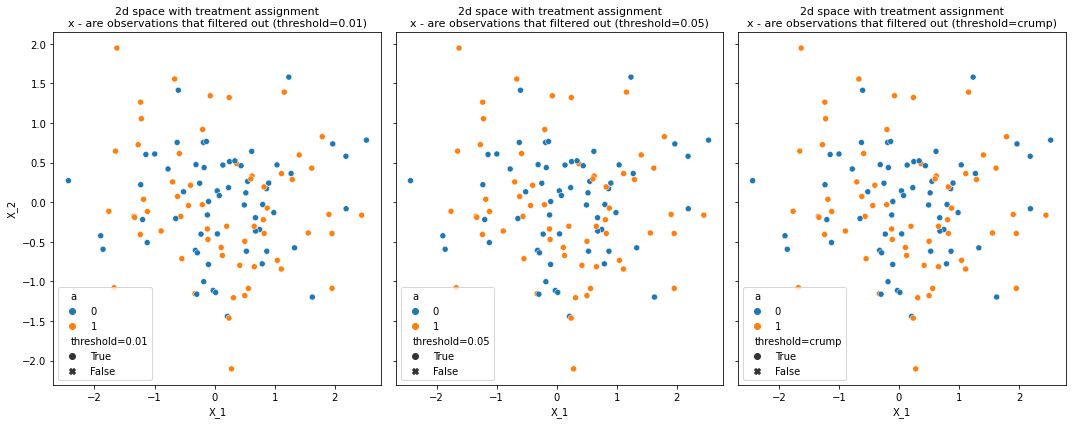

In [32]:
# create 2d overlapping data 
X, a = make_classification(n_samples=120, n_features=2, n_redundant=0, n_informative=1,
                           random_state=1, n_clusters_per_class=1, class_sep=0)
X, a = pd.DataFrame(X), pd.Series(a)

df = create_trimmed_data(X, a)
plot_trimmed_obs_2d_spcae(data, number_of_methods=3)

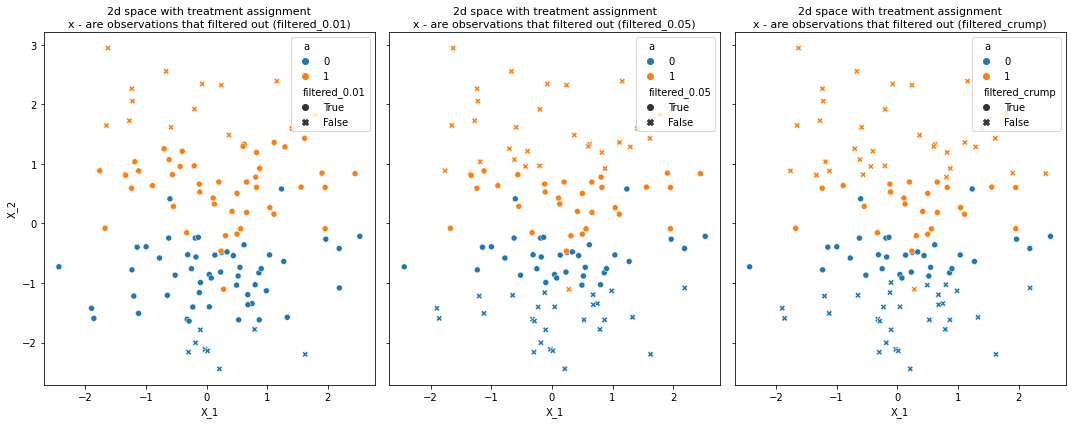

In [43]:
# create parialy seperated dataset 
X, a = make_classification(n_samples=120, n_features=2, n_redundant=0, n_informative=1,
                           random_state=1, n_clusters_per_class=1, class_sep=1)
X, a = pd.DataFrame(X), pd.Series(a)

df = create_trimmed_data(X, a)
plot_trimmed_obs_2d_spcae(df, number_of_methods=3)

# Matching Positivity Checker

One way to filter samples as violating positivity assumption or not is to match them and only return samples that successfully matched. Here we show how a positivity checker can be used that is based on the matching logic in causallib.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sb

from causallib.positivity import Matching
from causallib.datasets import load_nhefs
data = load_nhefs(augment=False,onehot=False)
X, a, y = data.X, data.a, data.y

In [3]:
m=Matching(with_replacement=False)
m.fit(X, a)
overlap=m.predict(X, a)

In [10]:
assert(min(len(a) - a.sum(), a.sum()) * 2 == overlap.sum())

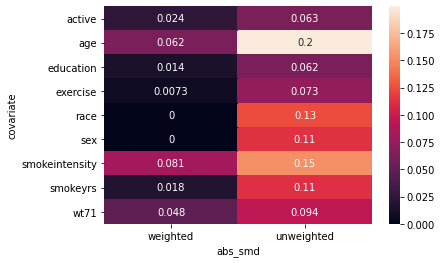

In [7]:
from causallib.evaluation.weight_evaluator import calculate_covariate_balance
covbalance = calculate_covariate_balance(X, a, overlap)
sb.heatmap(covbalance, annot=True);

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pc1,pc2 = TSNE(n_components=2).fit_transform(X).T

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

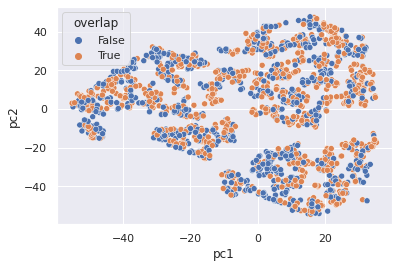

In [9]:
Xaug = X.join(a).assign(pc1=pc1,pc2=pc2,overlap=overlap)
sb.set("notebook")
sb.scatterplot(x="pc1", y="pc2", hue="overlap", markers="qsmk", data=Xaug)

# Univariate Bounding Box Positivity Checker

One way to filter samples as violating the positivity assumption or not is to check for overlap on each variable. As a univariate problem, this is straightforward and we can either use raw min/max to estimate support, quantiles or other methods. Here we have implemented the raw and quantile versions.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from causallib.positivity import UnivariateBoundingBox
from causallib.datasets import load_nhefs
data = load_nhefs(augment=False, onehot=False)
X, a, y = data.X, data.a, data.y

The basic usage is like the other modules, supporting `fit` and `predict`:

In [3]:
uvbb = UnivariateBoundingBox(quantile_alpha=0.05, continuous_columns=["age", "smokeintensity", "smokeyrs", "wt71"])
uvbb.fit(X, a)
overlap = uvbb.predict(X, a)

We can view the results in a table:

In [4]:
uvbb.supports_table_

,treatment,control,joint
active,"support: {0, 1, 2}","support: {0, 1, 2}","support: {0, 1, 2}"
age,"support: [26.0, 69.0]","support: [25.0, 67.0]","support: [26.0, 67.0]"
education,"support: {1, 2, 3, 4, 5}","support: {1, 2, 3, 4, 5}","support: {1, 2, 3, 4, 5}"
exercise,"support: {0, 1, 2}","support: {0, 1, 2}","support: {0, 1, 2}"
race,"support: {0, 1}","support: {0, 1}","support: {0, 1}"
sex,"support: {0, 1}","support: {0, 1}","support: {0, 1}"
smokeintensity,"support: [1.0, 40.0]","support: [3.0, 45.0]","support: [3.0, 40.0]"
smokeyrs,"support: [6.0, 52.0]","support: [5.0, 48.0]","support: [6.0, 48.0]"
wt71,"support: [47.0655, 106.79149999999998]","support: [46.72, 104.52200000000002]","support: [47.0655, 104.52200000000002]"


We can use the subtract operation on the support objects to check the regions of lack of overlap:

In [5]:
uvbb.supports_table_["treatment"] - uvbb.supports_table_["control"]

active                                                  {}
age                                             [1.0, 2.0]
education                                               {}
exercise                                                {}
race                                                    {}
sex                                                     {}
smokeintensity                                [-2.0, -5.0]
smokeyrs                                        [1.0, 4.0]
wt71              [0.34550000000000125, 2.269499999999965]
dtype: object

This, in turn, defines a kind of score: how much of a support mismatch is there, in standardized units:

We'll want to have a nice way to visualize the results so we'll make some plotting helper functions

In [6]:
def plot_support(supports, ax):
    heights = [2, 1, 0]
    xmin = [s.support[0] for s in supports]
    xmax = [s.support[1] for s in supports]
    ax.hlines(y=heights, xmin=min(xmin), xmax=max(xmax), ls=":")
    ax.hlines(y=heights, xmin=xmin, xmax=xmax,
              colors=["white"], lw=10, alpha=1)
    ax.hlines(y=heights, xmin=xmin, xmax=xmax, colors=[
              "blue", "black", "orange"], lw=10, alpha=0.5)
    for h, label in zip(heights, ["treatment", "joint", "control"]):
        midpoint = (min(xmin) + max(xmax))/2
        ax.text(midpoint, h, label, horizontalalignment='center',
                verticalalignment='center', color="white", fontweight="bold", fontsize="large")
    ax.set_yticks([])
    ax.set_ylim(-0.5, 2.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


def plot_supports(uvbb, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(5, 5))
    for ax, c in zip(axes, columns):
        support_list = [uvbb.treatment_support_[c],
                        uvbb.joint_support_[c], uvbb.control_support_[c]]
        plot_support(support_list, ax)
        ax.set_ylabel(c)

    plt.tight_layout()

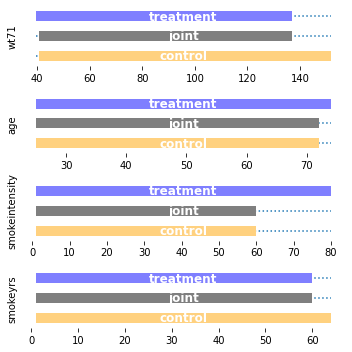

In [7]:
plot_supports(
    UnivariateBoundingBox(quantile_alpha=None,
                          continuous_columns=[
                              "age", "smokeintensity", "smokeyrs", "wt71"]
                          ).fit(X, a),
    ["wt71", "age", "smokeintensity", "smokeyrs"]
)

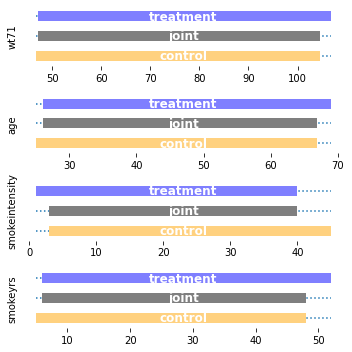

In [8]:
plot_supports(
    UnivariateBoundingBox(quantile_alpha=0.05,
                          continuous_columns=[
                              "age", "smokeintensity", "smokeyrs", "wt71"]
                          ).fit(X, a),
    ["wt71", "age", "smokeintensity", "smokeyrs"]
)

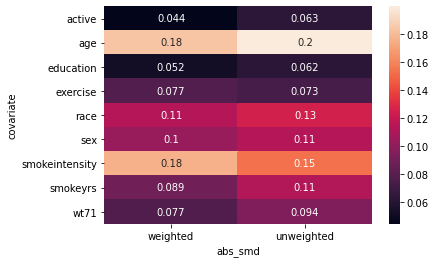

In [9]:
import seaborn as sb
from causallib.evaluation.weight_evaluator import calculate_covariate_balance
covbalance = calculate_covariate_balance(X, a, UnivariateBoundingBox(quantile_alpha=0.05).fit_predict(X, a))
sb.heatmap(covbalance, annot=True);

I am not happy with the results of this heatmap. It is showing that the trimming does not help the `abs_smd` even for variables like `smokeintensity`. I don't really see how that makes sense.

## Lalonde

This is a great positivity dataset because we know it has problems. Let's see how our simple system works for that:

In [10]:
columns = ["training",   # Treatment assignment indicator
           "age",        # Age of participant
           "education",  # Years of education
           "black",      # Indicate whether individual is black
           "hispanic",   # Indicate whether individual is hispanic
           "married",    # Indicate whether individual is married
           "no_degree",  # Indicate if individual has no high-school diploma
           "re74",       # Real earnings in 1974, prior to study participation
           "re75",       # Real earnings in 1975, prior to study participation
           "re78"]       # Real earnings in 1978, after study end
file_names = ["http://www.nber.org/~rdehejia/data/nswre74_treated.txt",
              "http://www.nber.org/~rdehejia/data/nswre74_control.txt",
              "http://www.nber.org/~rdehejia/data/psid_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid2_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid3_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps2_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps3_controls.txt"]
files = [pd.read_csv(file_name, delim_whitespace=True,
                     header=None, names=columns) for file_name in file_names]
lalonde = pd.concat(files, ignore_index=True)
lalonde = lalonde.sample(frac=1.0, random_state=42)  # Shuffle
lalonde = lalonde.sample(frac=1.0, random_state=42)  # Shuffle
lalonde = lalonde.join(
    (lalonde[["re74", "re75"]] == 0).astype(int), rsuffix=("=0"))

print(lalonde.shape)

a_ll = lalonde.pop("training")
y_ll = lalonde.pop("re78")
X_ll = lalonde

(22106, 12)


We want the categoricals to be correctly identified as such. For our purposes today we'll treat years of education as a continuous number.

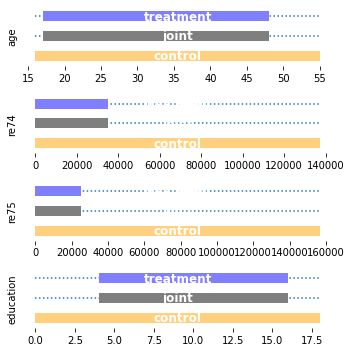

In [11]:
uvbbll = UnivariateBoundingBox(0.0, continuous_columns=["age", "re74", "re75", "education"]).fit(X_ll, a_ll)

plot_supports(uvbbll, ["age", "re74", "re75", "education"])

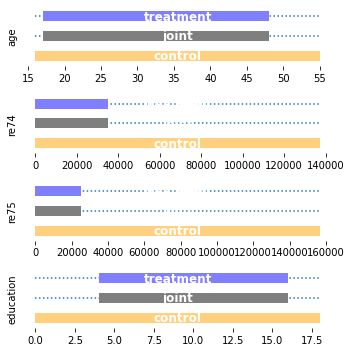

In [12]:
uvbbll_q005 = UnivariateBoundingBox(0.05, continuous_columns=["age", "re74", "re75", "education"]).fit(X_ll, a_ll)

plot_supports(uvbbll, ["age", "re74", "re75", "education"])

In [13]:
uvbbll.supports_table_

,treatment,control,joint
age,"support: [17.0, 48.0]","support: [16.0, 55.0]","support: [17.0, 48.0]"
education,"support: [4.0, 16.0]","support: [0.0, 18.0]","support: [4.0, 16.0]"
black,"support: [0.0, 1.0]","support: [0.0, 1.0]","support: [0.0, 1.0]"
hispanic,"support: [0.0, 1.0]","support: [0.0, 1.0]","support: [0.0, 1.0]"
married,"support: [0.0, 1.0]","support: [0.0, 1.0]","support: [0.0, 1.0]"
no_degree,"support: [0.0, 1.0]","support: [0.0, 1.0]","support: [0.0, 1.0]"
re74,"support: [0.0, 35040.07]","support: [0.0, 137148.68]","support: [0.0, 35040.07]"
re75,"support: [0.0, 25142.24]","support: [0.0, 156653.23]","support: [0.0, 25142.24]"
re74=0,"support: {0, 1}","support: {0, 1}","support: {0, 1}"
re75=0,"support: {0, 1}","support: {0, 1}","support: {0, 1}"


In [14]:
uvbbll.supports_table_["treatment"] - uvbbll.supports_table_["control"]

age                         [1.0, -7.0]
education                   [4.0, -2.0]
black                        [0.0, 0.0]
hispanic                     [0.0, 0.0]
married                      [0.0, 0.0]
no_degree                    [0.0, 0.0]
re74         [0.0, -102108.60999999999]
re75         [0.0, -131510.99000000002]
re74=0                               {}
re75=0                               {}
dtype: object

## Possible scoring by measuring escape from bounding box
This is an experimental idea by which we can tell the "score" of the fit by reporting the largest overlap violation in standardized units. It is not included in the main module because it is still experimental.

In [15]:
def score(uvbb, full_output=False):
    support_diff = (uvbb.scaled_supports_table_["treatment"] - uvbb.scaled_supports_table_["control"])
    rescaled_delta_df = support_diff[support_diff.apply(bool)]
    if not full_output:
        return  abs(np.vstack(rescaled_delta_df)).max()
    return rescaled_delta_df

In [16]:
score(uvbb,False)

0.41880441363664245

In [17]:
score(uvbbll, False)

19.54002226126555

<h1> Multiple treatment positivity </H1>

We assume that every patient received one treatment

When considering multiple treatments we need to asses the positivity estimation scheme. In the binary case we will have an experimental group and control group in that case we would want to unconfound each treatment group against the control. We provide a scheme that enable positivity estimation even without a control group. In The notebook we present two meta-schemes for multiple treatment positivity that uses a basic positivity algorithm such as Trimming.
For further theoritical discussion we reffer the reader to the paper: <a href='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4219328/'> Theoritical basis of multiple treatments and multiple versions by Miguel A. HernÃ¡n </href>

<h2> One versus another </h2>
In this meta algorithm we asses the positivity of pairs of treatments. In the default mode this scheme will asses the pairwise positivity but if a control group is defined we can asses the positivity of each treatment against the control group. Or define which pairs specifically should be considered. <br> <br>
Let's create some simulation data

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
from causallib.positivity import Trimming
from causallib.positivity.multiple_treatment_positivity import OneVersusRestPositivity, OneVersusAnotherPositivity
import numpy as np
import seaborn as sns

def create_simulated_data():
    X, y = make_classification(
            n_samples=500,
            n_features=3,
            n_informative=2,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            flip_y=0.01,
            class_sep=1.0,
            random_state=899,
        )
    X, a = X[:, :-1], pd.Series(
        pd.qcut(X[:, -1], 5, labels=[1, 2, 3, 4, 5], retbins=True)[0].to_numpy()
    )
    index_ = ['patient_'+str(i) for i in range(500)]
    return {
        "X": pd.DataFrame(X,index=index_),
        "a": pd.Series(data=a.values,index=index_),
        "y": pd.Series(data = y,index=index_),
    }

<h3> With a control group </h3>
Let's assume that treatment five is the control group. so we will define the versus another positivity with trimming as the base algorithm. Here each treatment is measured individually versus treatment five only.

In [2]:
data = create_simulated_data()
pos_one_vs_control = OneVersusAnotherPositivity(Trimming(),verbose=False, treatment_pairs_list=5, treatment_a_name='Treatment', treatment_b_name='Control')
pos_one_vs_control.fit(data['X'],data['a'])

OneVersusAnotherPositivity(base_positivity_estimator=Trimming(threshold='crump'),
                           treatment_a_name='Treatment',
                           treatment_b_name='Control',
                           treatment_pairs_list=[(4, 5), (2, 5), (3, 5),
                                                 (1, 5)])

We can view the positivity profile of each patient on the tuple he was treated. Notice that the estimation population is both i.e the treated and control groups.<br>
Note that the None values are for the patient that were not included in the single positivity estimations.

In [3]:
profile = pos_one_vs_control.positivity_profile(data['X'],data['a'],estimation_population='Both').head()
profile['a']  =data['a']
profile.head()

Treatment,4,2,3,1,a
Control,5,5,5,5,
patient_0,True,NaN,NaN,NaN,4
patient_1,True,NaN,NaN,NaN,4
patient_2,NaN,True,NaN,NaN,2
patient_3,NaN,NaN,True,NaN,3
patient_4,True,True,True,True,5


We can review the report for every patient - for those who are in the data but not necessarily were part of the control or treated groups for the single estimator. Treated and control modes are available as well.

In [4]:
profile = pos_one_vs_control.positivity_profile(data['X'],data['a'],estimation_population='Every').head()
profile['a']  =data['a']
profile.head()

Treatment,4,2,3,1,a
Control,5,5,5,5,
patient_0,True,True,True,False,4
patient_1,True,True,True,True,4
patient_2,True,True,True,True,2
patient_3,True,False,True,False,3
patient_4,True,True,True,True,5


We can also view a report per treatment, same modes are available as before.

In [5]:
pos_one_vs_control.treatment_positivity_summary(data['X'],a=data['a'])

Control,5
Treatment,
1,0.760
2,0.885
3,1.000
4,1.000


We can see the rate of the overlapping cases per treated group.

<H3> Without a control group </H3>
In this case we will set a pairwise positivity. The default value (None) of the versus_list will be turned into a list containing a tuple per pair. <br>
Because of the large number of estimators we would consider setting verbose to true.

In [6]:
pos_one_vs_another = OneVersusAnotherPositivity(Trimming(),verbose=True)
pos_one_vs_another.fit(data['X'],data['a'])

Fitting treatment 10


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 10/10 [00:06<00:00,  1.59it/s]


OneVersusAnotherPositivity(base_positivity_estimator=Trimming(threshold='crump'),
                           treatment_pairs_list=[(4, 2), (4, 3), (4, 5), (4, 1),
                                                 (2, 3), (2, 5), (2, 1), (3, 5),
                                                 (3, 1), (5, 1)],
                           verbose=True)

Let's view the report

In [7]:
pos_one_vs_another.treatment_positivity_summary(data['X'],a=data['a'],estimation_population='Both')

treatmentB,1,2,3,5
treatmentA,,,,
2,1.00,NaN,1.0,0.885
3,1.00,NaN,NaN,1.000
4,0.80,0.945,1.0,1.000
5,0.76,NaN,NaN,NaN


The rows are for the first treatment in the tuple and the columns are for the second treatment in tuple. The report is not symmetric because treatment one for example, appears only as the first treatment.
This report has the same modes as the previous. If we want a symmetric report we can use the contingency profile.

<AxesSubplot:>

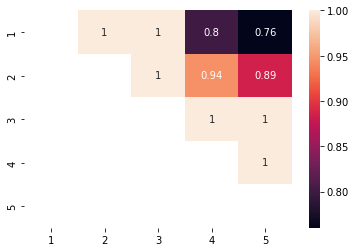

In [8]:
con = pos_one_vs_another.treatment_positivity_summary(data['X'],a=data['a'],estimation_population='Both',as_contingency_table=True)
sns.heatmap(con,annot=True)

Now we can do a cool trick we will create a contingency table were i,j is the rate of i treated cases that overlap between i and j and cell j,i is the rate of j cases that overlap between i and j. 

<AxesSubplot:>

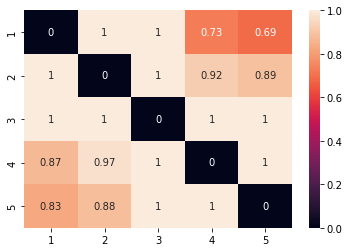

In [9]:
tr = pos_one_vs_another.treatment_positivity_summary(data['X'],a=data['a'],estimation_population='treated',as_contingency_table=True)
cr = pos_one_vs_another.treatment_positivity_summary(data['X'],a=data['a'],estimation_population='control',as_contingency_table=True)
con = tr.fillna(0)+cr.fillna(0).T
sns.heatmap(con,annot=True)

This is a excessive report the diagonal is non relevant

<H2> One versus the the rest </H2>
In this scheme we require a similar case that was treated with any other treatment, we asses positivity when each treatment is the treatment group and the control is all of the other treatments combined. 

In [10]:
pos_one_vs_rest = OneVersusRestPositivity(Trimming(),verbose=True)
pos_one_vs_rest.fit(data['X'],data['a'])
pos_one_vs_rest.positivity_profile(data['X'],data['a']).head() 

Fitting 5 treatment


,1,2,3,4,5
patient_0,False,False,True,True,True
patient_1,True,True,True,True,True
patient_2,True,True,True,True,True
patient_3,False,False,True,True,True
patient_4,True,True,True,True,True


Note that every treatment here is in the positivity population

In [11]:
pos_one_vs_rest.treatment_positivity_summary(data['X'],a=data['a'])


1    0.882
2    0.880
3    1.000
4    0.942
5    0.878
dtype: float64

And here we can see the contingency table as well

<AxesSubplot:>

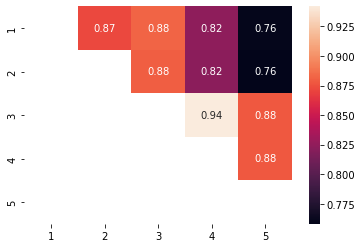

In [12]:
con = pos_one_vs_rest.treatment_positivity_summary(data['X'],a=data['a'],as_contingency_table=True)
sns.heatmap(con,annot=True)